         Date  ASM_Domestic  ASM_International  Flights_Domestic  \
0  2002-10-01       3145924          3621595.0             21018   
1  2002-11-01       2979775          3497708.0             19952   
2  2002-12-01       3121668          3742268.0             20607   
3  2003-01-01       3033226          3670713.0             20146   
4  2003-02-01       2666412          3254882.0             17954   

   Flights_International  Passengers_Domestic  Passengers_International  \
0                 3649.0              1584391                  555909.0   
1                 3625.0              1522333                  533949.0   
2                 3878.0              1703329                  630439.0   
3                 3807.0              1517819                  579915.0   
4                 3314.0              1359793                  482550.0   

   RPM_Domestic  RPM_International  
0       2182810          2722551.0  
1       2056578          2509096.0  
2       2369511          2881

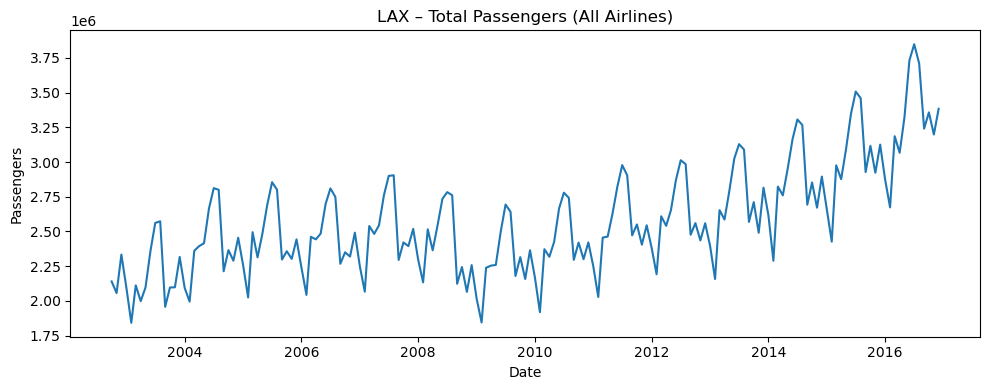

Saved cleaned data to: c:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_D_LAX_Airport_Growth_Prediction\output\clean\all_airlines_lax_clean.csv


In [2]:
import pandas as pd
from pathlib import Path

# -------------------------------------------------------------------
# Paths
# -------------------------------------------------------------------
PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_RAW = PROJECT_ROOT / "data" / "raw" / "all_airlines-LAX.csv"
OUTPUT_CLEAN_DIR = PROJECT_ROOT / "output" / "clean"
OUTPUT_CLEAN_DIR.mkdir(parents=True, exist_ok=True)

# -------------------------------------------------------------------
# Load raw data
# -------------------------------------------------------------------
df = pd.read_csv(DATA_RAW)

# Basic inspection
print(df.head())
print(df.dtypes)

# -------------------------------------------------------------------
# Clean & standardise
# -------------------------------------------------------------------
# Parse dates and set month-start
df["date"] = pd.to_datetime(df["Date"])
df["date"] = pd.to_datetime(df["Date"]).dt.to_period("M").dt.to_timestamp()

# Create snake_case columns
df = df.rename(
    columns={
        "ASM_Domestic": "asm_domestic",
        "ASM_International": "asm_international",
        "Flights_Domestic": "flights_domestic",
        "Flights_International": "flights_international",
        "Passengers_Domestic": "passengers_domestic",
        "Passengers_International": "passengers_international",
        "RPM_Domestic": "rpm_domestic",
        "RPM_International": "rpm_international",
    }
)

# Total metrics
df["pax_total"] = df["passengers_domestic"] + df["passengers_international"]
df["flights_total"] = df["flights_domestic"] + df["flights_international"]
df["asm_total"] = df["asm_domestic"] + df["asm_international"]
df["rpm_total"] = df["rpm_domestic"] + df["rpm_international"]

# Keep useful columns only
df = df[
    [
        "date",
        "passengers_domestic",
        "passengers_international",
        "pax_total",
        "flights_domestic",
        "flights_international",
        "flights_total",
        "asm_domestic",
        "asm_international",
        "asm_total",
        "rpm_domestic",
        "rpm_international",
        "rpm_total",
    ]
].sort_values("date")

# -------------------------------------------------------------------
# Ensure continuous monthly index (no gaps)
# -------------------------------------------------------------------
full_index = pd.date_range(df["date"].min(), df["date"].max(), freq="MS")
df = df.set_index("date").reindex(full_index)
df.index.name = "date"

# If there are any missing rows, you’ll see them here
print("Missing rows after reindex:", df.isna().any(axis=1).sum())

# (Optional) If there are a few NaNs, you can decide what to do later
# for now we’ll just drop rows with missing pax_total
df = df.dropna(subset=["pax_total"])

# -------------------------------------------------------------------
# Quick visual sanity check (optional)
# -------------------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(df.index, df["pax_total"])
plt.title("LAX – Total Passengers (All Airlines)")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# Export cleaned dataset
# -------------------------------------------------------------------
clean_path = OUTPUT_CLEAN_DIR / "all_airlines_lax_clean.csv"
df.to_csv(clean_path)
print(f"Saved cleaned data to: {clean_path}")
